In [1]:
import pandas as pd
import os
import pytz

In [3]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [9]:
# 파일 불러오기
one_df = pd.read_parquet("/content/drive/MyDrive/data/one_time_buyers_all_events.parquet")
multi_df = pd.read_parquet("/content/drive/MyDrive/data/multi_buyers_all_events.parquet")

# 1. 먼저 "1회 구매자"의 첫 구매 이후 데이터를 추출해야 함
one_purchase = one_df[one_df['event_type'] == 'purchase']
one_purchase['event_date'] = pd.to_datetime(one_purchase['event_date'])

# 유저별 첫 구매일 추출
first_purchase = one_purchase.groupby('user_id')['event_date'].min().reset_index(name='first_date')

# 이 유저들이 이후에 한 다른 구매들 추출
one_with_later = one_df.merge(first_purchase, on='user_id')
one_with_later['event_date'] = pd.to_datetime(one_with_later['event_date'])
after_first = one_with_later[(one_with_later['event_type'] == 'purchase') &
                             (one_with_later['event_date'] > one_with_later['first_date'])]

# 2. category_lvl2 기준 분포 계산
after_first_dist = after_first['category_lvl2'].value_counts(normalize=True).reset_index()
after_first_dist.columns = ['category_lvl2', 'rate_after_first']

# 3. 다회 구매자 전체 구매 분포
multi_purchase = multi_df[multi_df['event_type'] == 'purchase']
multi_dist = multi_purchase['category_lvl2'].value_counts(normalize=True).reset_index()
multi_dist.columns = ['category_lvl2', 'rate_multi']

# 4. 병합 후 비교
compare_df = pd.merge(after_first_dist, multi_dist, on='category_lvl2', how='outer').fillna(0)
compare_df['rate_diff'] = compare_df['rate_after_first'] - compare_df['rate_multi']
compare_df = compare_df.sort_values('rate_diff', ascending=False)

/tmp/ipython-input-9-4196983864.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_purchase['event_date'] = pd.to_datetime(one_purchase['event_date'])


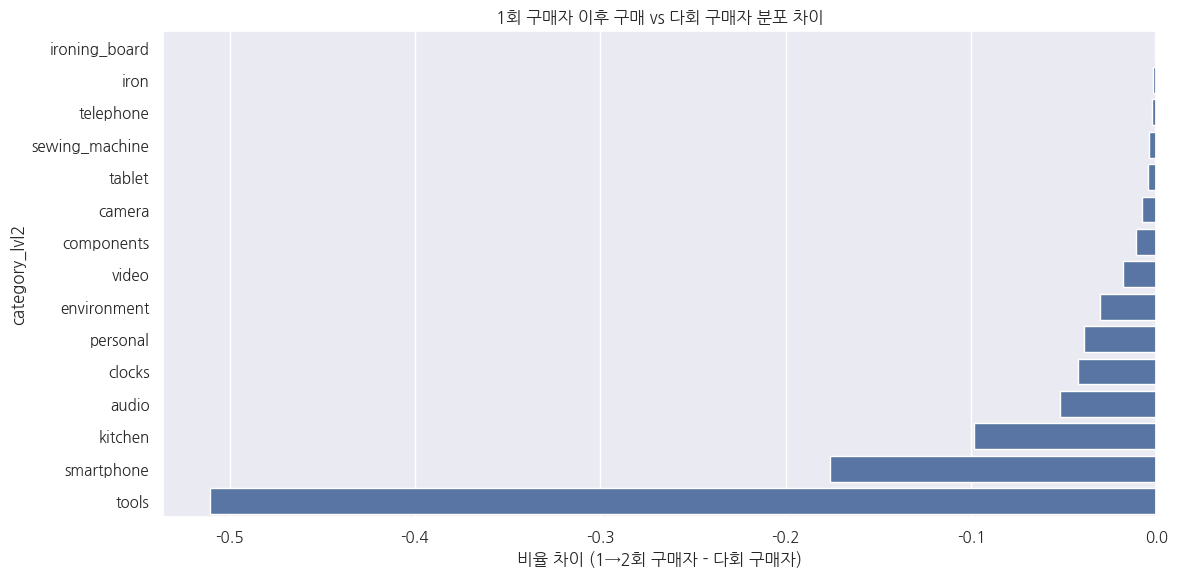

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(data=compare_df, x='rate_diff', y='category_lvl2')
plt.title('1회 구매자 이후 구매 vs 다회 구매자 분포 차이')
plt.xlabel('비율 차이 (1→2회 구매자 - 다회 구매자)')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
from collections import Counter

# 구매 이벤트만 필터
one_purchase = one_df[one_df['event_type'] == 'purchase'].copy()
multi_purchase = multi_df[multi_df['event_type'] == 'purchase'].copy()

# datetime 변환 및 정렬
one_purchase['event_date'] = pd.to_datetime(one_purchase['event_date'])
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])

one_purchase = one_purchase.sort_values(['user_id', 'event_date'])
multi_purchase = multi_purchase.sort_values(['user_id', 'event_date'])

# 결측치 처리
one_purchase['category_lvl2'] = one_purchase['category_lvl2'].fillna('unknown')
multi_purchase['category_lvl2'] = multi_purchase['category_lvl2'].fillna('unknown')

# 유저별 구매 시퀀스 추출 함수
def get_paths(df):
    paths = df.groupby('user_id')['category_lvl2'].apply(list)
    path_3seq = paths.apply(lambda x: [tuple(x[i:i+3]) for i in range(len(x)-2)] if len(x) >= 3 else []).tolist()
    flat_paths = [p for sublist in path_3seq for p in sublist]
    return Counter(flat_paths)

# 경로 빈도 추출
one_paths = get_paths(one_purchase)
multi_paths = get_paths(multi_purchase)

# 데이터프레임화
one_path_df = pd.DataFrame(one_paths.items(), columns=['path', 'count_one'])
multi_path_df = pd.DataFrame(multi_paths.items(), columns=['path', 'count_multi'])

# 병합 및 차이 비교
merged_paths = pd.merge(one_path_df, multi_path_df, on='path', how='outer').fillna(0)
merged_paths['diff'] = merged_paths['count_multi'] - merged_paths['count_one']
merged_paths = merged_paths.sort_values('diff', ascending=False)

# 상위 10개 변화 많은 경로 보기
merged_paths.head(10)


/tmp/ipython-input-11-3326151610.py:35: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_paths = pd.merge(one_path_df, multi_path_df, on='path', how='outer').fillna(0)


,path,count_one,count_multi,diff
2496,"(tools, tools, tools)",0,881629,881629
1911,"(smartphone, smartphone, smartphone)",0,254251,254251
1304,"(kitchen, kitchen, kitchen)",0,77925,77925
0,"(audio, audio, audio)",0,45041,45041
391,"(clocks, clocks, clocks)",0,39262,39262
1958,"(smartphone, tools, tools)",0,38723,38723
1525,"(personal, personal, personal)",0,32345,32345
1914,"(smartphone, smartphone, tools)",0,31418,31418
1398,"(kitchen, tools, tools)",0,28372,28372
2490,"(tools, tools, kitchen)",0,22705,22705


In [12]:
import pandas as pd
from collections import Counter

# 구매 이벤트만 필터
one_purchase = one_df[one_df['event_type'] == 'purchase'].copy()
multi_purchase = multi_df[multi_df['event_type'] == 'purchase'].copy()

# datetime 변환 및 정렬
one_purchase['event_date'] = pd.to_datetime(one_purchase['event_date'])
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])

one_purchase = one_purchase.sort_values(['user_id', 'event_date'])
multi_purchase = multi_purchase.sort_values(['user_id', 'event_date'])

# 결측치 처리
one_purchase['category_lvl2'] = one_purchase['category_lvl2'].fillna('unknown')
multi_purchase['category_lvl2'] = multi_purchase['category_lvl2'].fillna('unknown')

# 유저별 카테고리 경로 (최대 길이 제한 없이)
def get_n_step_paths(df, max_n=2):
    paths = df.groupby('user_id')['category_lvl2'].apply(list)
    all_seqs = []
    for path in paths:
        for n in range(1, max_n+1):
            all_seqs += [tuple(path[i:i+n]) for i in range(len(path)-n+1)]
    return Counter(all_seqs)

one_paths = get_n_step_paths(one_purchase, max_n=2)
multi_paths = get_n_step_paths(multi_purchase, max_n=2)

# 데이터프레임화
one_path_df = pd.DataFrame(one_paths.items(), columns=['path', 'count_one'])
multi_path_df = pd.DataFrame(multi_paths.items(), columns=['path', 'count_multi'])

# 병합 및 차이 비교
merged_paths = pd.merge(one_path_df, multi_path_df, on='path', how='outer').fillna(0)
merged_paths['diff'] = merged_paths['count_multi'] - merged_paths['count_one']
merged_paths = merged_paths.sort_values('diff', ascending=False)

# 상위 10개 변화 많은 경로 보기
merged_paths.head(10)


,path,count_one,count_multi,diff
208,"(tools,)",288936.0,1715321,1426385.0
222,"(tools, tools)",0.0,1232456,1232456.0
160,"(smartphone,)",141568.0,592208,450640.0
171,"(smartphone, smartphone)",0.0,383222,383222.0
112,"(kitchen,)",86249.0,330474,244225.0
120,"(kitchen, kitchen)",0.0,154475,154475.0
0,"(audio,)",39068.0,174155,135087.0
32,"(clocks,)",26643.0,141966,115323.0
128,"(personal,)",30369.0,131905,101536.0
1,"(audio, audio)",0.0,82288,82288.0


In [16]:
# 1. 구매 이벤트 필터링
one_purchase = one_df[one_df['event_type'] == 'purchase']
multi_purchase = multi_df[multi_df['event_type'] == 'purchase']

# 2. 유저별 category_lvl1 개수
one_user_cat1 = one_purchase.groupby('user_id')['category_lvl1'].nunique().reset_index()
multi_user_cat1 = multi_purchase.groupby('user_id')['category_lvl1'].nunique().reset_index()

one_user_cat1['group'] = '1회 구매자'
multi_user_cat1['group'] = '2회 이상 구매자'

# 3. 통합 및 카테고리 범주화
cat1_combined = pd.concat([one_user_cat1, multi_user_cat1])
cat1_combined['category_type'] = cat1_combined['category_lvl1'].apply(
    lambda x: '1개만 구매' if x == 1 else '2개 이상 구매'
)

# 4. 비율 계산
cat1_ratio = cat1_combined.groupby(['group', 'category_type'])['user_id'].count().reset_index()
cat1_ratio['ratio'] = cat1_ratio.groupby('group')['user_id'].transform(lambda x: x / x.sum())

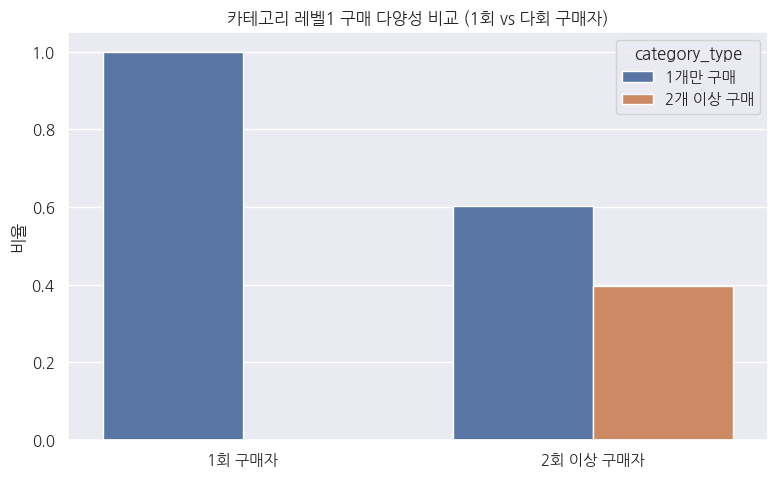

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(data=cat1_ratio, x='group', y='ratio', hue='category_type')
plt.title('카테고리 레벨1 구매 다양성 비교 (1회 vs 다회 구매자)')
plt.ylabel('비율')
plt.xlabel('')
plt.tight_layout()
plt.show()


In [18]:
# 구매 이벤트만 필터링
multi_purchase = multi_df[multi_df['event_type'] == 'purchase'].copy()

# 날짜 정렬
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])
multi_purchase = multi_purchase.sort_values(by=['user_id', 'event_date'])

# 유저별 구매 순서 부여
multi_purchase['purchase_order'] = multi_purchase.groupby('user_id').cumcount() + 1

# 첫 번째, 두 번째 구매만 추출
first_second = multi_purchase[multi_purchase['purchase_order'] <= 2]

# 첫/두 번째 구매를 하나의 행에 피벗
pivoted = first_second.pivot(index='user_id', columns='purchase_order', values='category_lvl1')
pivoted.columns = ['first_cat1', 'second_cat1']
pivoted = pivoted.dropna()

# 변경 여부 판단
pivoted['category_changed'] = pivoted['first_cat1'] != pivoted['second_cat1']

# 통계 요약
change_rate = pivoted['category_changed'].mean()
change_counts = pivoted['category_changed'].value_counts()

print("2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율:", round(change_rate, 3))
print("\n상세 분포:")
print(change_counts)


2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율: 0.219

상세 분포:
category_changed
False    503688
True     141510
Name: count, dtype: int64


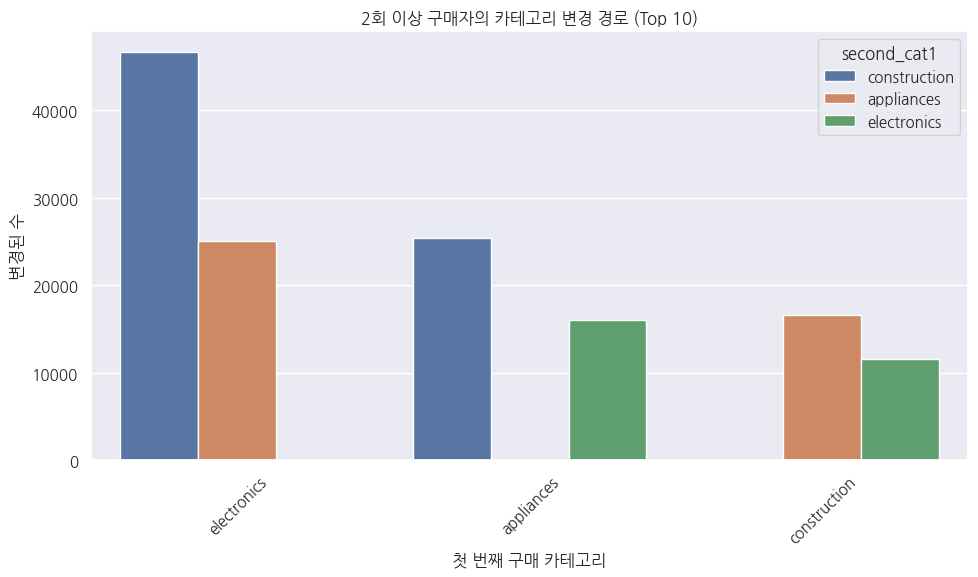

In [19]:
# 변경된 경우만 추출
changed_cases = pivoted[pivoted['category_changed']]

# 변화 경로 집계
change_paths = changed_cases.groupby(['first_cat1', 'second_cat1']).size().reset_index(name='count')
change_paths = change_paths.sort_values('count', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

# 상위 몇 개만 시각화
top_paths = change_paths.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_paths, y='count', x='first_cat1', hue='second_cat1')
plt.title('2회 이상 구매자의 카테고리 변경 경로 (Top 10)')
plt.xlabel('첫 번째 구매 카테고리')
plt.ylabel('변경된 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

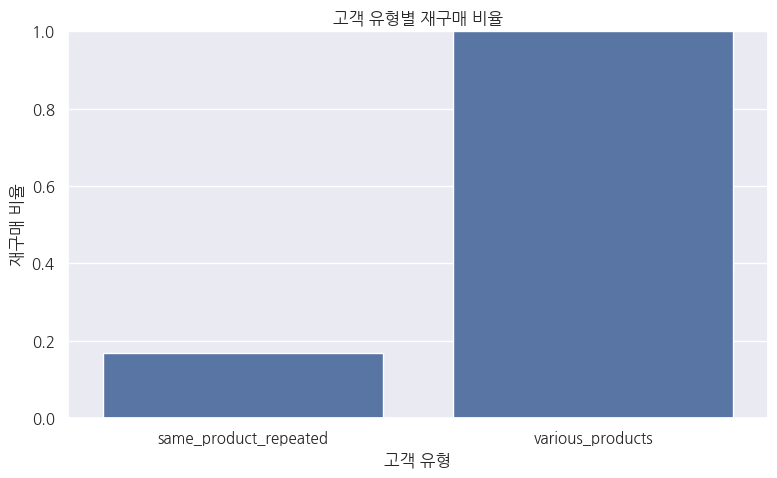

In [20]:
# 구매 이벤트만 필터링
one_purchase = one_df[one_df['event_type'] == 'purchase']
multi_purchase = multi_df[multi_df['event_type'] == 'purchase']

# 1회 구매자: user_id 기준으로 유형 분류
one_profile = (
    one_purchase.groupby('user_id')['product_id']
    .agg(['count', 'nunique'])
    .reset_index()
    .rename(columns={'count': 'total_purchases', 'nunique': 'unique_products'})
)

# 2회 이상 구매자: 동일
multi_profile = (
    multi_purchase.groupby('user_id')['product_id']
    .agg(['count', 'nunique'])
    .reset_index()
    .rename(columns={'count': 'total_purchases', 'nunique': 'unique_products'})
)

# 공통 분류 함수
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    elif row['unique_products'] >= 2:
        return 'various_products'
    else:
        return 'unknown'

# 유형 컬럼 추가
one_profile['user_type'] = one_profile.apply(classify_user, axis=1)
multi_profile['user_type'] = multi_profile.apply(classify_user, axis=1)

# 전체 고객 수 대비 재구매한 비율 계산
summary = (
    pd.concat([
        one_profile.assign(is_repurchase=0),
        multi_profile.assign(is_repurchase=1)
    ])
    .groupby(['user_type', 'is_repurchase'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 재구매율 계산
summary['repurchase_rate'] = summary[1] / (summary[0] + summary[1])

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(data=summary, x='user_type', y='repurchase_rate')
plt.title('고객 유형별 재구매 비율')
plt.ylabel('재구매 비율')
plt.xlabel('고객 유형')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
